In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme(style='white', palette='mako')

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
date_columns = ['date', 'inference_time']
categoric_columns = ['month', 'week', 'day_of_week', 'day', 'year', 'week_in_month']
dtype_categoric = dict([(c,'category') for c in categoric_columns])

data = pd.read_csv('../../data/avocados_demand_forecasting_dataset.csv', dtype=dtype_categoric, parse_dates=date_columns)

In [3]:
data

,date,demand,inference_time,month,week,week_in_month,day,days_since_last_holiday,days_until_next_holiday,average_price_in_last_1_weeks,...,total_volume_in_last_3_weeks,total_volume_3_weeks_ago,total_volume_in_last_4_weeks,total_volume_4_weeks_ago,total_volume_in_last_5_weeks,total_volume_5_weeks_ago,total_volume_in_last_6_weeks,total_volume_6_weeks_ago,total_volume_in_last_7_weeks,total_volume_7_weeks_ago
0,2015-03-01,8.943484e+07,2015-02-22,2,8,4,22,52.0,1191.0,1.375139,...,9.065940e+07,1.194532e+08,8.782078e+07,7.646628e+07,8.624878e+07,7.838878e+07,8.514978e+07,7.855581e+07,8.509035e+07,8.467434e+07
1,2015-03-08,8.128167e+07,2015-03-01,3,9,1,1,59.0,1184.0,1.336852,...,8.315480e+07,8.667111e+07,9.041449e+07,1.194532e+08,8.808979e+07,7.646628e+07,8.670393e+07,7.838878e+07,8.568541e+07,7.855581e+07
2,2015-03-15,7.967682e+07,2015-03-08,3,10,2,8,66.0,1177.0,1.335556,...,8.180744e+07,7.563716e+07,8.278018e+07,8.667111e+07,8.889235e+07,1.194532e+08,8.711720e+07,7.646628e+07,8.602615e+07,7.838878e+07
3,2015-03-22,8.734632e+07,2015-03-15,3,11,3,15,73.0,1170.0,1.376019,...,8.281736e+07,8.087609e+07,8.138132e+07,7.563716e+07,8.226295e+07,8.667111e+07,8.757585e+07,1.194532e+08,8.618715e+07,7.646628e+07
4,2015-03-29,8.084341e+07,2015-03-22,3,12,4,22,80.0,1163.0,1.370602,...,8.443491e+07,8.943484e+07,8.372315e+07,8.087609e+07,8.237549e+07,7.563716e+07,8.298915e+07,8.667111e+07,8.754716e+07,1.194532e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,2018-02-25,1.092314e+08,2018-02-18,2,7,3,18,1144.0,99.0,1.340556,...,1.245855e+08,1.097951e+08,1.230858e+08,1.170872e+08,1.195761e+08,1.020277e+08,1.168934e+08,1.007971e+08,1.153008e+08,1.041529e+08
157,2018-03-04,1.118449e+08,2018-02-25,2,8,4,25,1151.0,92.0,1.366852,...,1.244445e+08,1.691778e+08,1.215147e+08,1.097951e+08,1.207767e+08,1.170872e+08,1.180983e+08,1.020277e+08,1.159357e+08,1.007971e+08
158,2018-03-11,1.114652e+08,2018-03-04,3,9,1,4,1158.0,85.0,1.354907,...,1.101113e+08,1.175776e+08,1.219246e+08,1.691778e+08,1.199030e+08,1.097951e+08,1.195008e+08,1.170872e+08,1.173166e+08,1.020277e+08
159,2018-03-18,1.136740e+08,2018-03-11,3,10,2,11,1165.0,78.0,1.342639,...,1.085832e+08,1.017913e+08,1.103821e+08,1.175776e+08,1.201814e+08,1.691778e+08,1.186976e+08,1.097951e+08,1.184963e+08,1.170872e+08


In [4]:
train_start_date = data['inference_time'].min()
train_end_date = data['inference_time'].min() + pd.DateOffset(months=15)
test_end_date = train_end_date + pd.DateOffset(months=3)
prod_end_date = data['inference_time'].max()

# Create data partition
data['partition'] = pd.cut(
    data['inference_time'],
    bins= [train_start_date,
           train_end_date,
           test_end_date,
           prod_end_date],
    right=False,
    labels= ['train', 'test', 'prod']
)

# Set target and features
target = 'demand'
features = [col for col in data.columns if col not in [target, 'partition'] + date_columns]

# Split the data
X_train = data.loc[data['partition'] == 'train', features]
y_train = data.loc[data['partition'] == 'train', target]

X_test = data.loc[data['partition'] == 'test', features]
y_test = data.loc[data['partition'] == 'test', target]

X_prod = data.loc[data['partition'] == 'prod', features]
y_prod = data.loc[data['partition'] == 'prod', target]

## Exploring the training data

In [5]:
X_train

,month,week,week_in_month,day,days_since_last_holiday,days_until_next_holiday,average_price_in_last_1_weeks,average_price_1_weeks_ago,average_price_in_last_2_weeks,average_price_2_weeks_ago,...,total_volume_in_last_3_weeks,total_volume_3_weeks_ago,total_volume_in_last_4_weeks,total_volume_4_weeks_ago,total_volume_in_last_5_weeks,total_volume_5_weeks_ago,total_volume_in_last_6_weeks,total_volume_6_weeks_ago,total_volume_in_last_7_weeks,total_volume_7_weeks_ago
0,2,8,4,22,52.0,1191.0,1.375139,1.387593,1.353580,1.310463,...,9.065940e+07,1.194532e+08,8.782078e+07,7.646628e+07,8.624878e+07,7.838878e+07,8.514978e+07,7.855581e+07,8.509035e+07,8.467434e+07
1,3,9,1,1,59.0,1184.0,1.336852,1.362685,1.353765,1.387593,...,8.315480e+07,8.667111e+07,9.041449e+07,1.194532e+08,8.808979e+07,7.646628e+07,8.670393e+07,7.838878e+07,8.568541e+07,7.855581e+07
2,3,10,2,8,66.0,1177.0,1.335556,1.311019,1.344599,1.362685,...,8.180744e+07,7.563716e+07,8.278018e+07,8.667111e+07,8.889235e+07,1.194532e+08,8.711720e+07,7.646628e+07,8.602615e+07,7.838878e+07
3,3,11,3,15,73.0,1170.0,1.376019,1.360093,1.354352,1.311019,...,8.281736e+07,8.087609e+07,8.138132e+07,7.563716e+07,8.226295e+07,8.667111e+07,8.757585e+07,1.194532e+08,8.618715e+07,7.646628e+07
4,3,12,4,22,80.0,1163.0,1.370602,1.391944,1.367099,1.360093,...,8.443491e+07,8.943484e+07,8.372315e+07,8.087609e+07,8.237549e+07,7.563716e+07,8.298915e+07,8.667111e+07,8.754716e+07,1.194532e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,4,15,3,17,472.0,771.0,1.197546,1.173796,1.210154,1.235370,...,9.768709e+07,9.764452e+07,9.795740e+07,9.903866e+07,9.812724e+07,9.897642e+07,9.775946e+07,9.555282e+07,9.804209e+07,1.000205e+08
61,4,16,4,24,479.0,764.0,1.205463,1.221296,1.194907,1.173796,...,1.004582e+08,9.159912e+07,9.989545e+07,9.764452e+07,9.975265e+07,9.903866e+07,9.964176e+07,9.897642e+07,9.913065e+07,9.555282e+07
62,5,17,1,1,486.0,757.0,1.176667,1.189630,1.191543,1.221296,...,1.068791e+08,1.000183e+08,1.038231e+08,9.159912e+07,1.027934e+08,9.764452e+07,1.022570e+08,9.903866e+07,1.018469e+08,9.897642e+07
63,5,18,2,8,493.0,750.0,1.156111,1.163704,1.167284,1.189630,...,1.134008e+08,1.014864e+08,1.107243e+08,1.000183e+08,1.075368e+08,9.159912e+07,1.061236e+08,9.764452e+07,1.052380e+08,9.903866e+07


In [6]:
df = data.loc[data['partition'] == 'train', ['date', 'demand', 'week_in_month', 'month']]
df['week'] = df['date'].dt.to_period('W')

df1 = df.copy()
df1['demand'] = df1['demand'] / 1000000
df1 = df1.reset_index()
df2 = df.groupby('month')['demand'].sum() / 1000000
df2 = df2.reset_index()

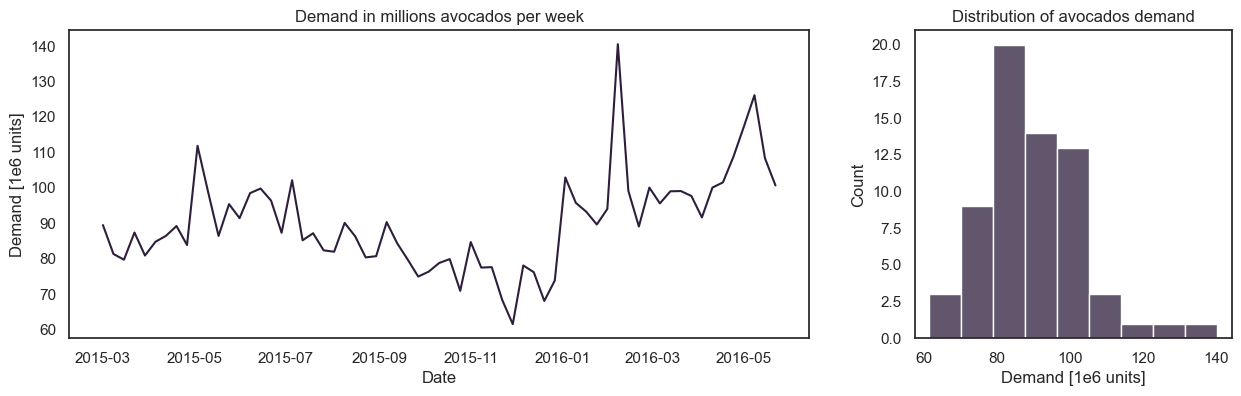

In [7]:
fig, ax = plt.subplots(1, 2, width_ratios=[70, 30], figsize=(15, 4))

sns.lineplot(data=df1, x='date', y='demand', ax=ax[0])
ax[0].set_title('Demand in millions avocados per week')
ax[0].set_ylabel('Demand [1e6 units]')
ax[0].set_xlabel('Date')

sns.histplot(data=df1, x='demand', ax=ax[1])
ax[1].set_title('Distribution of avocados demand')
ax[1].set_xlabel('Demand [1e6 units]')
plt.savefig('../../figures/avocados_demand_timeseries_and_distribution.svg', format='svg', bbox_inches='tight')
plt.show()

In [8]:
columns = np.append(X_train.columns.values, 'demand')
df = data.loc[data['partition'] == 'train']
df = df[columns]

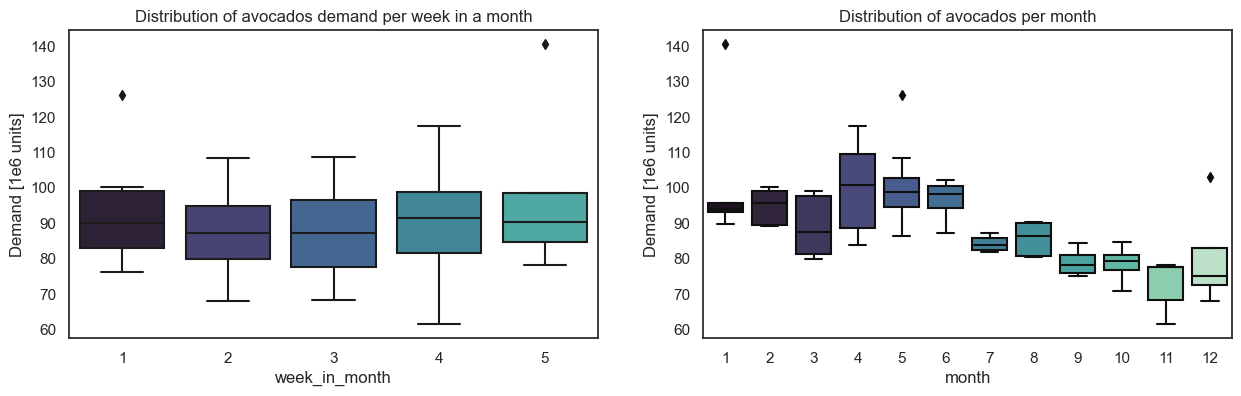

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
sns.boxplot(data=df1, x='week_in_month', y='demand', ax=ax[0])
ax[0].set_title('Distribution of avocados demand per week in a month')
ax[0].set_ylabel('Demand [1e6 units]')

sns.boxplot(data=df1, x='month', y='demand', order=[str(i) for i in range(1, 13)], ax=ax[1], palette='mako')
ax[1].set_title('Distribution of avocados per month')
ax[1].set_ylabel('Demand [1e6 units]')
plt.savefig('../../figures/avocados_week_month_demand.svg', format='svg', bbox_inches='tight')
plt.show()

/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_89914/817679423.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


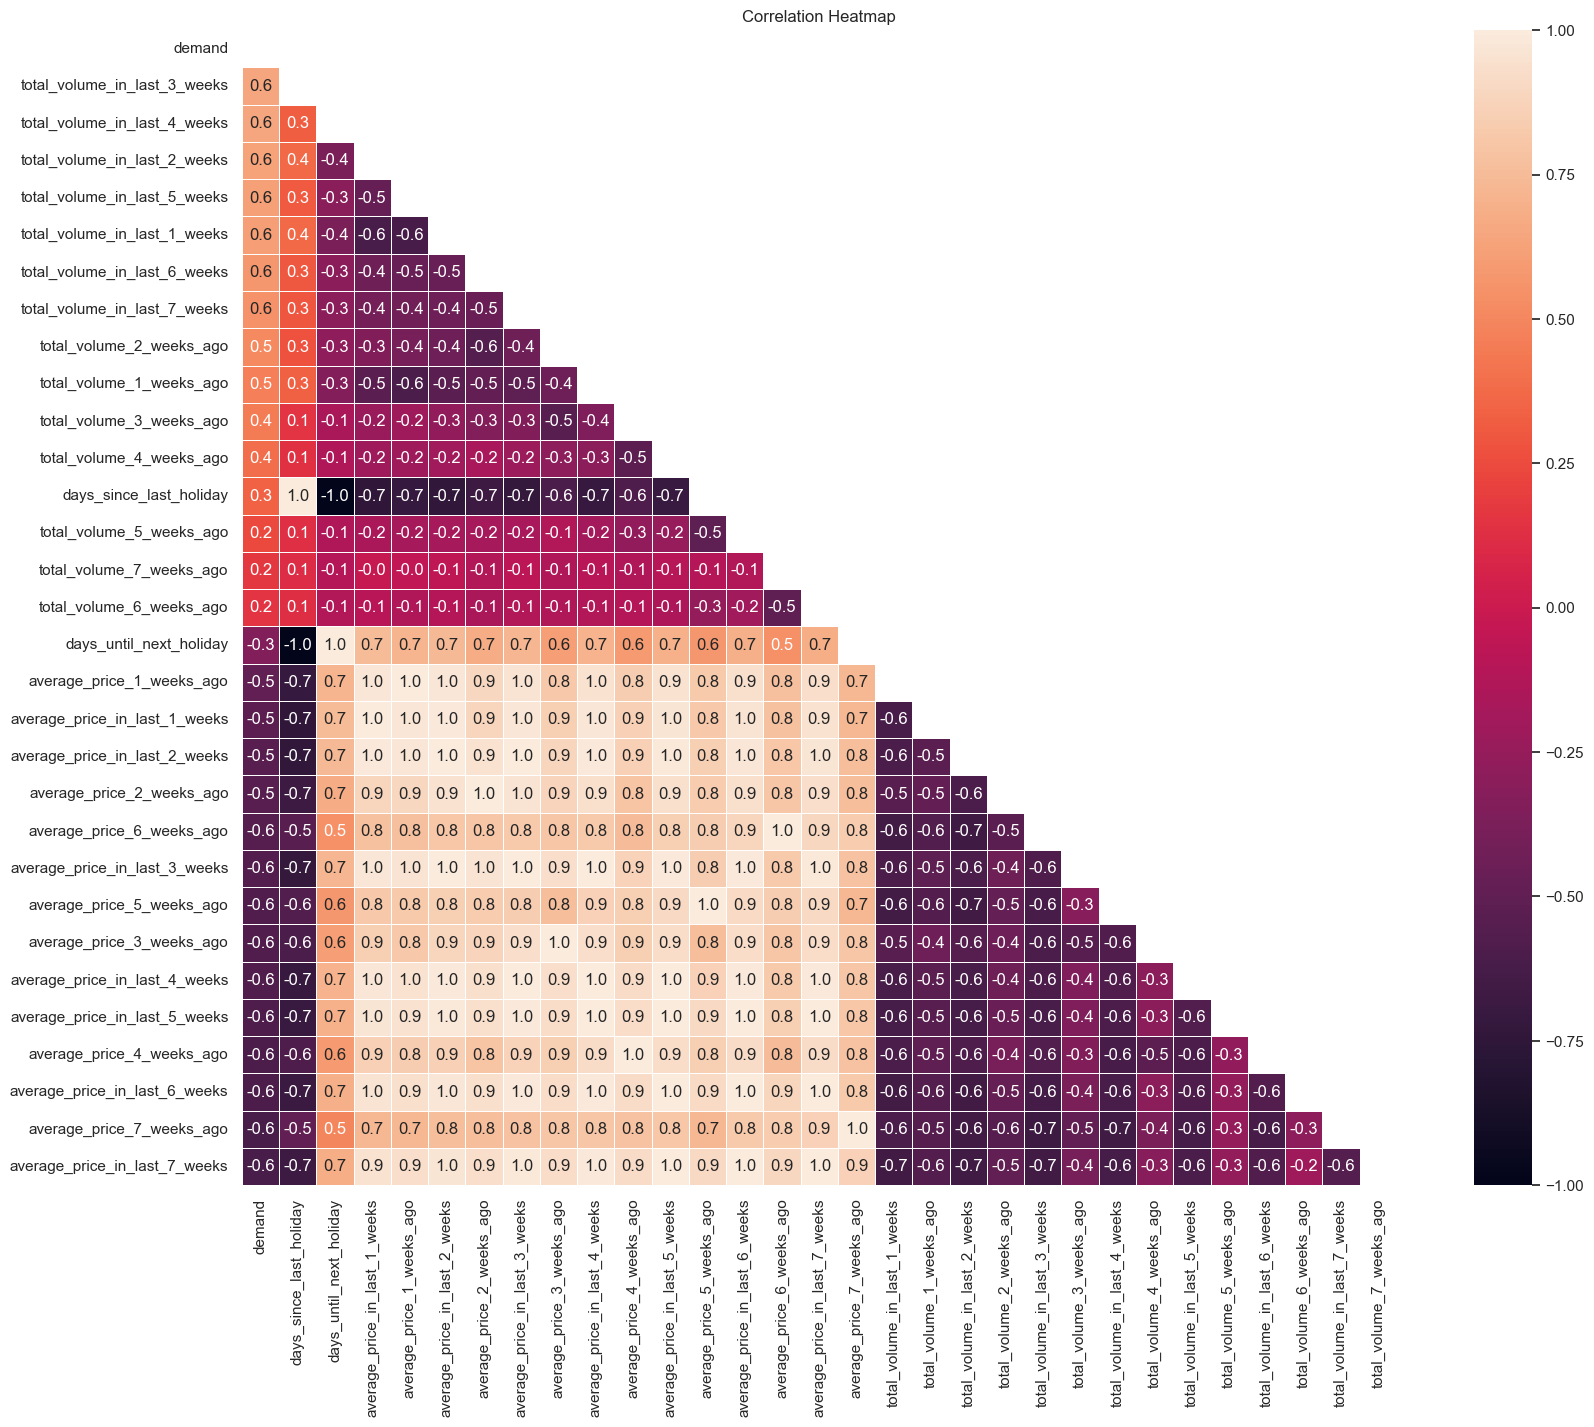

In [10]:
fig, ax = plt.subplots(figsize=(20,15))
corr = df.corr()
cols = list(corr.columns.values)
cols.insert(0, cols.pop(cols.index('demand')))
corr = corr.loc[:, cols].sort_values(by=['demand'], ascending=False)
mask = np.triu(corr)
sns.heatmap(corr, mask=mask, square=True, annot=True, fmt=".1f", linewidth=.5)
ax.set_title('Correlation Heatmap')
plt.savefig('../../figures/avocados_heatmap.svg', format='svg', bbox_inches='tight')
plt.show()

## Train a model

In [11]:
from lightgbm import LGBMRegressor, plot_importance
model = LGBMRegressor(random_state=111)
model.fit(X_train, y_train)

LGBMRegressor(random_state=111)

In [12]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Evaluate the model

In [13]:
# Make baseline predictions
y_pred_train_baseline = np.ones_like(y_train) * y_train.mean()
y_pred_test_baseline = np.ones_like(y_test) * y_train.mean()

# Measure train, test and baseline performance
mape_train = mean_absolute_percentage_error(y_train, y_pred_train).round(4)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test).round(4)

mape_train_baseline = mean_absolute_percentage_error(y_train, y_pred_train_baseline).round(4)
mape_test_baseline = mean_absolute_percentage_error(y_test, y_pred_test_baseline).round(4)

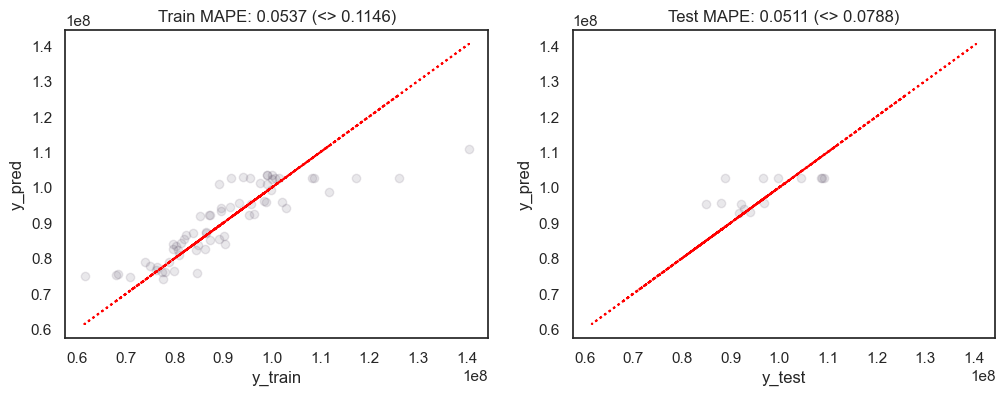

In [14]:
# Create performance report 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

upper_lim = max(y_train.max(), y_test.max(), y_pred_train.max(), y_pred_test.max())

title1 = 'Train MAPE: {} (<> {})'.format(mape_train, mape_train_baseline) 
ax1.set(title=title1, xlabel='y_train', ylabel='y_pred')
ax1.plot(y_train, y_train, color='red', linestyle=':')
ax1.scatter(y_train, y_pred_train, alpha=0.1)
# ax1.set_xlim(0, upper_lim)
# ax1.set_ylim(0, upper_lim)

title2 = 'Test MAPE: {} (<> {})'.format(mape_test, mape_test_baseline)
ax2.set(title=title2, xlabel='y_test', ylabel='y_pred')
ax2.plot(y_train, y_train, color='red', linestyle=':')
ax2.scatter(y_test, y_pred_test, alpha=0.1)
ax2.set
# ax2.set_xlim(0, upper_lim)
# ax2.set_ylim(0, upper_lim)

plt.savefig('../../figures/avocados_model_plots.svg', format='svg', bbox_inches='tight')
plt.show()

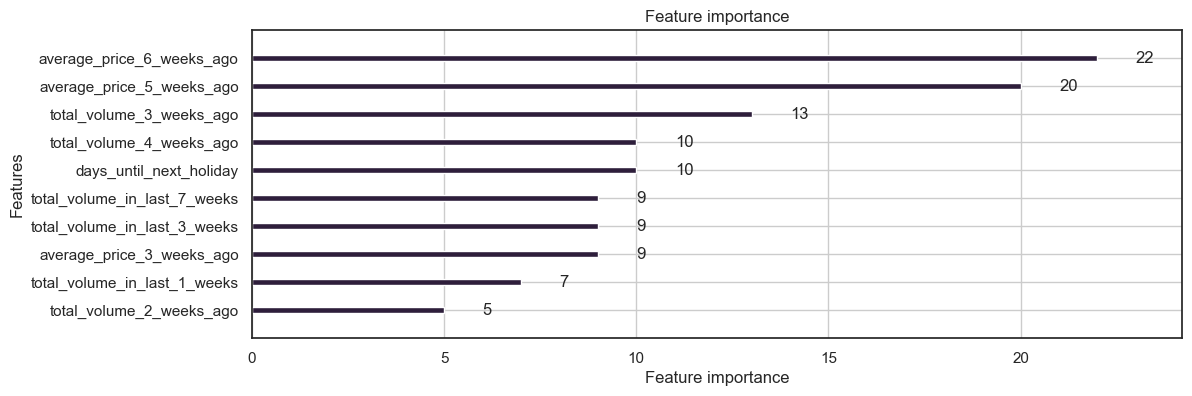

In [15]:
fig, ax = plt.subplots(figsize=(12,4))
plot_importance(model, ax=ax, max_num_features=10)
# plt.savefig('fig_2.png', dpi=300)
plt.savefig('../../figures/avocados_model_feature_importance.svg', format='svg', bbox_inches='tight')
plt.show()

## Making predictions

In [16]:
data['predicted_demand'] = model.predict(data[features])

## Post-deployment model analysis

In [17]:
def vspan(ax, ax2=None):
    handles, labels = ax.get_legend_handles_labels()
    
    if len(handles) > 3:
        handles = handles[:2]
        labels = labels[:2]
    else:
        handles = handles[:1]
        labels = labels[:1]
    
    if ax2:
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles2 = handles2[1]
        labels2 = labels2[1]
        
        handles = handles + [handles2]
        labels = labels + ['mean_absolute_error']

    ax.axvspan(train_start_date, train_end_date, color='#44AF69', alpha=0.25, zorder=-10)
    legend_patch = mpatches.Patch(color='#44AF69', alpha=0.25, label='Train')
    handles.append(legend_patch)
    labels.append('Train')

    ax.axvspan(train_end_date, test_end_date, color='#F2DC5D', alpha=0.125, zorder=-10)
    legend_patch = mpatches.Patch(color='#F2DC5D', alpha=0.125, label='Test')
    handles.append(legend_patch)
    labels.append('Test')

    ax.legend(handles=handles, labels=labels)

In [18]:
df = data[['date', 'demand', 'predicted_demand']].copy()
df['month'] = df['date'].dt.to_period('M')
df['week'] = df['date'].dt.to_period('W')

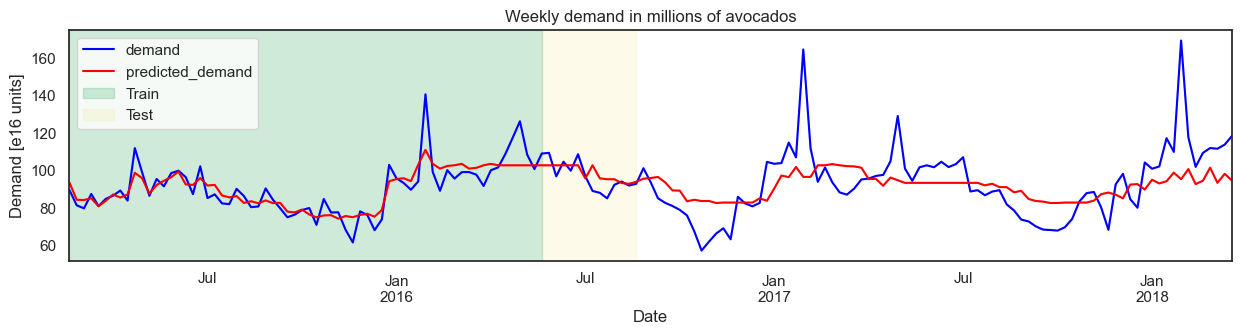

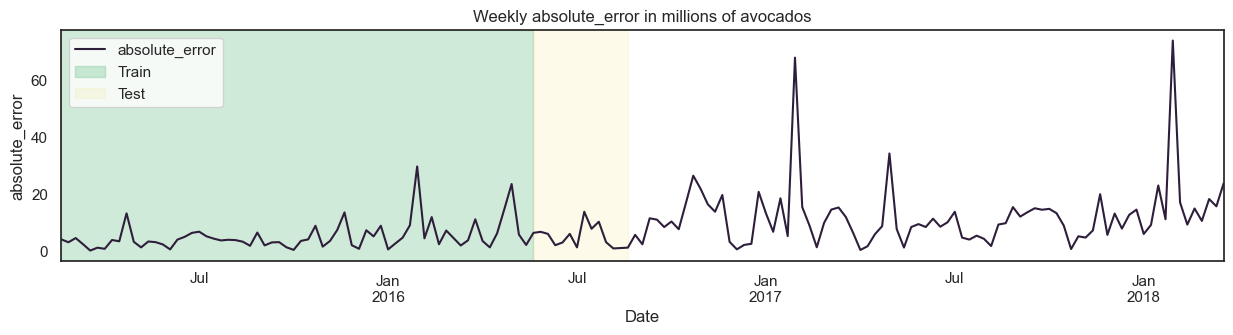

In [19]:
daily_demand = df.groupby('week')[['demand', 'predicted_demand']].sum() / 1000000
daily_demand['absolute_error'] = (daily_demand['demand'] - daily_demand['predicted_demand']).abs()
daily_demand.index = daily_demand.index.to_timestamp()

fig, ax = plt.subplots(figsize=(15, 3))
ax.set_title('Weekly demand in millions of avocados')
daily_demand[['demand', 'predicted_demand']].rolling(window=1).mean().plot(ax=ax, color=['blue', 'red'])
daily_demand[['demand', 'predicted_demand']].plot(ax=ax, alpha=0.125, legend=False, color=['blue', 'red'])
vspan(ax)
ax.set(xlabel='Date', ylabel='Demand [e16 units]')
plt.savefig('../../figures/avocados_true_demand_vs_predicted_timeseries.svg', format='svg', bbox_inches='tight')


fig, ax = plt.subplots(figsize=(15, 3))
ax.set_title('Weekly absolute_error in millions of avocados')
daily_demand[['absolute_error']].plot(ax=ax, legend=False)
ax.set(xlabel='Date', ylabel='absolute_error')

vspan(ax)
plt.savefig('../../figures/avocados_weekly_absolute_error_timeseries.svg', format='svg', bbox_inches='tight')
plt.show()